In [1]:
import datetime
import numpy as np
import pickle as pkl
import seaborn as sns
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from graspologic.simulations import p_from_latent, sample_edges
from graspologic.inference import latent_distribution_test
from sklearn.metrics.pairwise import pairwise_kernels

/usr/local/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def make_a_graph(n, case=0, scale=0.3, loc=0.3):
    if case == 0:
        latent1 = stats.uniform.rvs(0, 1, size=n).reshape(-1, 1) * scale + loc
    elif case == 1: 
        latent1 = stats.beta.rvs(0.25, 0.25, size=n).reshape(-1, 1) * scale + loc
    elif case == 2:     
        latent1 = np.random.binomial(1, 0.5, n).reshape(-1, 1) * scale + loc
    p_mat1 = p_from_latent(latent1, rescale=False, loops=False)
    X_graph = sample_edges(p_mat1, directed=False, loops=False)
    return X_graph

In [4]:
def mc_iter(n, m, p, q, test_type, i=1):
    X_graph = make_a_graph(n, case=p)
    Y_graph = make_a_graph(m, case=q)    
    
    def metric_func(X, Y=None, workers=None):
        return pairwise_kernels(X, Y, metric="rbf", gamma=2)
    
    pval = latent_distribution_test(X_graph, Y_graph,
                                    test="hsic",
                                    metric=metric_func,
                                    n_components=1,
                                    workers=cpu_count() - 2,
                                    size_correction=test_type).pvalue
    
    return pval

In [5]:
def monte_carlo(n, m, p, q, test_type=False, mc_iters=1000):
    '''
    n: size of the first graph
    m: size of the second graph
    p: latent position of the first graph
    q: latent poisiton of the second graph
    test_type: boolean, to set size_correction
    mc_iters: number of monte-carlo-iterations
    '''
    pvals = np.zeros(mc_iters)
    
    pvals = [None] * mc_iters
    for i in tqdm(range(mc_iters)):
        pvals[i] = mc_iter(n, m, p, q, test_type)

    return np.array(pvals)

In [6]:
case_to_graph = {0: 'F_X', 1: 'F_Y', 2: 'F_Z'}

ns = [50, 100, 200, 300, 400, 500]
c = 10
mc_iters = 1000

The following (commented out) cell runs the simulation from scratch if uncommented. Depending on your system it can take hours days with the settings provided by default. To run a smaller simulation, decrease the number of monte carlo iterations used. If the following cell is not uncommented, the notebook will use data from our run to generate the figure.

In [7]:
# full_data = {}
# part_data = {}
# for j in range(3):
#     k = j
#     case = case_to_graph[j] + " vs. " + case_to_graph[k] 
    
#     print(str(datetime.datetime.now()) + ' current case: {}'.format(case))
#     print(str(datetime.datetime.now()) + ' unmodified ASE')
#     tests_size_sbm_unmodified = np.array([monte_carlo(n=i, m=c*i, p=j, q=k,
#                                                       mc_iters=mc_iters,
#                                                       test_type=False)
#                                          for i in ns])
#     print(str(datetime.datetime.now()) + ' corrected ASE')
#     tests_size_sbm_sampling = np.array([monte_carlo(n=i, m=c*i, p=j, q=k,
#                                                     mc_iters=mc_iters,
#                                                     test_type=True)
#                                        for i in ns])
#     # store every result of every test
#     full_data[case] = {'unmodified': tests_size_sbm_unmodified,
#                           'sampling': tests_size_sbm_sampling}
#     # store only the powers
#     size_sbm_unmodified = np.array([np.sum(i < 0.05)/mc_iters for i in tests_size_sbm_unmodified])
#     size_sbm_sampling = np.array([np.sum(i < 0.05)/mc_iters for i in tests_size_sbm_sampling])
#     part_data[case] = {'unmodified': size_sbm_unmodified,
#                           'sampling': size_sbm_sampling}

#     pkl.dump(full_data, open( "../data/graphs_rdpg_size_full.pkl", "wb" ) )
#     pkl.dump(part_data, open( "../data/graphs_rdpg_size_part.pkl", "wb" ) )

In [8]:
full_data = pkl.load(open( "../data/graphs_rdpg_size_full.pkl", "rb" ) )
part_data = pkl.load(open( "../data/graphs_rdpg_size_part.pkl", "rb" ) )

In [9]:
part_data

{'F_X vs. F_X': {'unmodified': array([0.285, 0.138, 0.093, 0.077, 0.076, 0.067]),
  'sampling': array([0.018, 0.026, 0.033, 0.034, 0.032, 0.035])},
 'F_Y vs. F_Y': {'unmodified': array([0.142, 0.091, 0.078, 0.054, 0.051, 0.051]),
  'sampling': array([0.042, 0.039, 0.035, 0.044, 0.047, 0.041])},
 'F_Z vs. F_Z': {'unmodified': array([0.103, 0.067, 0.064, 0.057, 0.057, 0.049]),
  'sampling': array([0.039, 0.039, 0.031, 0.047, 0.062, 0.053])}}

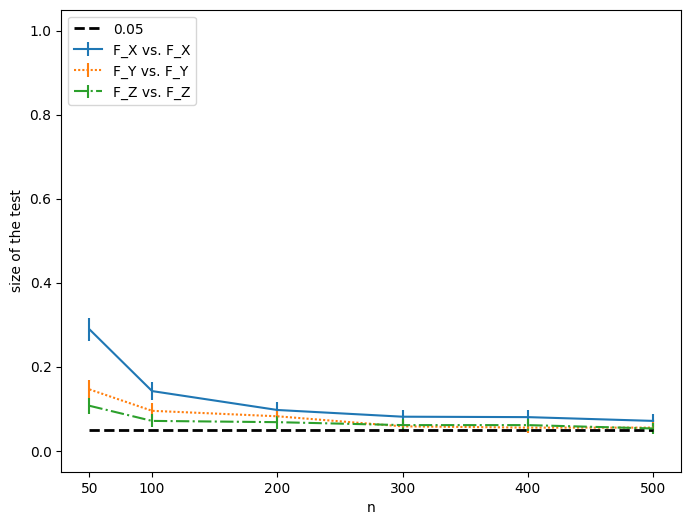

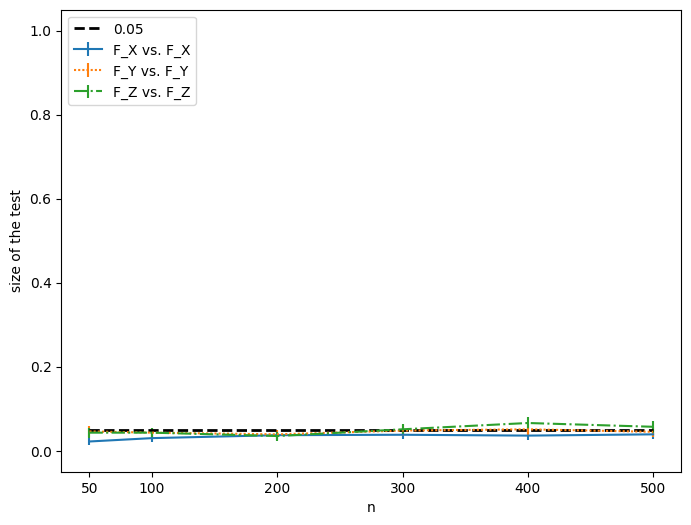

In [10]:
graph_type = 'rdpg'
size_power = 'size'
styles=['-', (0, (1, 1)), '-.', ':', (5, (10, 3)), '-', (0, (3, 5, 1, 5, 1, 5))]

for kernel_type in ['unmodified', 'sampling']:
    fig01, ax01 = plt.subplots(1, 1, figsize=(8,6))
    for j, k in zip(range(3), range(3)):
        case = case_to_graph[j] + " vs. " + case_to_graph[k]
        to_plot = part_data[case][kernel_type]
            
        ax01.errorbar(x = ns, y=to_plot+c*0.0004, linestyle=styles[j],
                      yerr=1.96*np.sqrt(to_plot*(1-to_plot)/mc_iters),
                      label=case)
    ax01.plot(ns, np.ones(len(ns)) * 0.05, 'k--', label='0.05', linewidth=2)
    ax01.set_xlabel("n")
    ax01.set_ylabel("{} of the test".format(size_power))
    ax01.set_ylim([-0.05, 1.05])
    ax01.set_xticks(ns)
    # ax01.legend(bbox_to_anchor=(1.04,1), loc="upper left");
    ax01.legend(loc="upper left")
    fig01.savefig('../figures/graphs_{}_{}_{}'.format(graph_type, size_power, kernel_type),
                  bbox_inches='tight', dpi=600);